# Data

Inspect, clean and balance synthetic grasp samples.

In [1]:
import os
import time

os.chdir('..')
import sys
sys.path.append('/media/yons/6d379145-c1d8-430f-9056-7777219c83a8/MISCGrasp')
sys.path.append('/media/yons/6d379145-c1d8-430f-9056-7777219c83a8/MISCGrasp/src')
sys.path.append('/opt/ros/noetic/lib/python3/dist-packages')

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pybullet as p
import pybullet_utils.bullet_client as bc

from src.gd.io import *
from src.gd.perception import *
from src.gd.utils.transform import Rotation, Transform
from data_generator.grasp.gripper_module import load_gripper

pybullet build time: Nov 28 2023 23:52:03


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Inspection

In [3]:
import rospy
from src.gd import vis

rospy.init_node("vgn_vis", anonymous=True)

Path to the data folder.

In [4]:
root = Path("/media/yons/6d379145-c1d8-430f-9056-7777219c83a8/MISCGrasp/data/datasets/data_misc/washed/pile")

Compute the number of positive and negative samples in the dataset.

In [5]:
df = pd.read_csv(root / "grasps.csv")
df = df[df['gripper_type'] == 'franka']

In [6]:
positives = df[df["label"] == 1]
negatives = df[df["label"] == 0]

print("Number of samples:", len(df.index))
print("Number of positives:", len(positives.index))
print("Number of negatives:", len(negatives.index))

GRIPPER_TYPES = [
    'franka',
]


Number of samples: 459300
Number of positives: 86082
Number of negatives: 373218


Visualize a random sample. Make sure to have a ROS core running and open `config/sim.rviz` in RViz.

In [7]:
size, intrinsic = read_setup(root)

In [10]:
two_finger = [
    'franka',
]

file_list = os.listdir(root / 'sensor_data')
trunc_file_list = sorted(file_list, key=lambda file: os.path.getctime(root / 'sensor_data' / file))
scene_id = np.random.choice(trunc_file_list).split('.')[0]
print(scene_id)

gripper_types = df[df['scene_id'] == scene_id]['gripper_type'].unique()
t = 'franka'
scales = df[df['scene_id'] == scene_id][df['gripper_type'] == t]['scale'].unique()
s = np.random.choice(list(scales))

grasps, labels = [], []
df_child = df[df['scene_id'] == scene_id][df['gripper_type'] == t][df['scale'] == s]
positives = df_child[df_child["label"] == 1]
negatives = df_child[df_child["label"] == 0]
if len(negatives) > len(positives):
    drop_indices = np.random.choice(negatives.index, len(negatives) - len(positives), replace=False)
    df_child = df_child.drop(drop_indices)
for i in df_child.index:
    rd = read_grasp(df, i)
    grasps.append(rd[3])
    labels.append(rd[4])

print(len(grasps) / 2)
world = bc.BulletClient(connection_mode=p.DIRECT)
gripper = load_gripper(t)(world, s)
finger_depth = gripper.finger_depth
max_opening_width = gripper.max_opening_width
print(t, s, finger_depth, max_opening_width)
for g in grasps:
    g.width *= max_opening_width

depth_imgs, extrinsics = read_sensor_data(root, scene_id)
tsdf = create_tsdf(size, 160, depth_imgs, intrinsic, extrinsics)
tsdf_low = create_tsdf(size, 80, depth_imgs, intrinsic, extrinsics)
tsdf_grid = tsdf.get_grid()
cloud = tsdf.get_cloud()

vis.clear()
vis.draw_workspace(size)
vis.draw_points(np.asarray(cloud.points))
vis.draw_tsdf(tsdf_grid, tsdf.voxel_size)
id = np.random.choice(np.arange(len(grasps)))
grasp, label = grasps[id], labels[id]
if gripper.name in two_finger:
    vis.draw_grasps(grasps, labels, finger_depth)
    vis.draw_grasp(grasp, label, finger_depth)
    

7201f2f1f43248b7b098a828b33e4548
16.0
franka 1.0 0.05 0.08


/tmp/ipykernel_434014/3613838954.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  scales = df[df['scene_id'] == scene_id][df['gripper_type'] == t]['scale'].unique()
/tmp/ipykernel_434014/3613838954.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_child = df[df['scene_id'] == scene_id][df['gripper_type'] == t][df['scale'] == s]
/tmp/ipykernel_434014/3613838954.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_child = df[df['scene_id'] == scene_id][df['gripper_type'] == t][df['scale'] == s]


Plot the distribution of angles between the gravity vector and $Z$ axis of grasps.

In [11]:
angles = np.empty(len(positives.index))
for i, index in enumerate(positives.index):
    approach = Rotation.from_quat(df.loc[index, "qx":"qw"].to_numpy()).as_matrix()[:,2]
    angle = np.arccos(np.dot(approach, np.r_[0.0, 0.0, -1.0]))
    angles[i] = np.rad2deg(angle)        

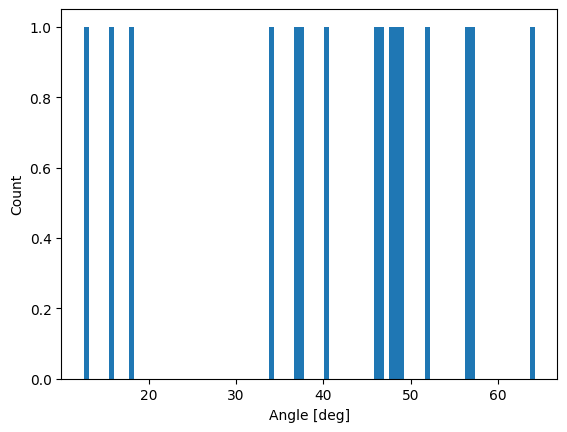

In [12]:
plt.hist(angles, bins=90)
plt.xlabel("Angle [deg]")
plt.ylabel("Count")
plt.show()